In [1]:
print("CardiAP v1.0")

CardiAP v1.0


In [2]:
# display
from IPython.display import HTML, display, clear_output

# widgets
import ipywidgets as widgets
from ipywidgets import Layout, Button, Box, Text, HBox, VBox

# tables encoding
import base64

# data analysis
import numpy as np
import pandas as pd


# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvas
import pyhrv.nonlinear as nl

# cardilib
from lib.image import image_data
from lib.image import image_data
from lib.analysis import dyssynchrony_analysis as dyssync

# image processing
from interactivecrop.interactivecrop import main as crop
from PIL import Image
import io
import cv2

import warnings

pd.set_option('display.max_rows', 20)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [10]:
def extract_transient_global_AR(file, column='amplitudes'):
    '''This function takes CardIAP whole cell analysis output.
    Returns a list of tuples with transients amplitudes'''
    transients_amplitudes = []
    for i in range(0,len(file)-1):
        transient1 = float(file[column][i])
        transient2 = float(file[column][i+1])
        transients_amplitudes.append((transient1,transient2))
    return transients_amplitudes

def extract_transient_local_AR(slice_df, column='amplitudes'):
    '''This function takes CardIAP slices analysis output .
    Returns a list of tuples with transients amplitudes'''
    transients_amplitudes = []
    for i in range(0,len(slice_df)-1):
        transient1 = float(slice_df[column][i])
        transient2 = float(slice_df[column][i+1])
        transients_amplitudes.append((transient1,transient2))
    return transients_amplitudes

def calculate_alternance_ratio(transients):
    '''Alternance Ratio (AR) was calculated as the difference in the magnitude of the two consecutive local transients / the amplitude of the largest transient.
'transients' parameter corresponds to 'calculate_AR' output.
The output is a list of AR'''
    AR_list = []
    for transient_tuple in transients:
        try:
            AR_list.append(abs(transient_tuple[0]-transient_tuple[1]))/max(transient_tuple[0], transient_tuple[1])
        except:
            pass
    return AR_list

def calculate_local_AR(file):
    '''This function run calculates the local and returns a df containing the slice's peaks values'''
    local_AR = []
    for slice_ in range(max(file['slice_number'])):
        slice_df = file[file['slice_number']== slice_].reset_index(drop=True)
        transients_amplitudes = extract_transient_local_AR(slice_df)
        AR = calculate_alternance_ratio(transients_amplitudes)
        local_AR.append(AR)
    local_AR_bypeaks_table = pd.DataFrame(local_AR)
    return local_AR_bypeaks_table

def get_discordance_indexes_table(local_AR_bypeaks_table):
    '''The discordance index (DI) is defined as the standard deviation of the measured local AR values.
    Input is 'calculate_alternance_ratio' of local AR output
    Output is a table containing the of DI'''
    return local_AR_bypeaks_table.std().to_list()

def calculate_global_AR(file):
    '''This function calculates the global AR global and returns the peaks values'''
    transients_amplitudes = extract_transient_global_AR(file)
    global_AR_bypeaks_list = calculate_alternance_ratio(transients_amplitudes)
    return global_AR_bypeaks_list

def global_data_table(file_slice,file_image):
    '''Builds the global data table'''
    local_AR_bypeaks_table = calculate_local_AR(file_slice)
    data_tuple = (get_discordance_indexes_table(local_AR_bypeaks_table),calculate_global_AR(file_image))
    global_data_df = pd.DataFrame(data_tuple, index=['DI','Global AR'])
    return global_data_df.T



def localAR_boxplot(local_AR_df):
    '''This function displays displays the boxplot from the local Alternance Ratio data table'''
    data = np.array(local_AR_df.dropna())
    fig7, ax7 = plt.subplots()
    ax7.set_title('Transient localAR distributions')
    ax7.boxplot(data)

    return plt


def get_global_dyssynchrony_results(analysis_result):
    '''From the analysis results, builds the summary of dyssynchrony'''
    file_slice = build_analysis_results_table(analysis_result,kind='slices')[0]
    file_image = build_analysis_results_table(analysis_result,kind='image')[0]
    return global_data_table(file_slice,file_image)


def plot_local_AR(analysis_result):
    '''From the analysis results, builds the local Alternance Ratio boxplot'''
    return localAR_boxplot(calculate_local_AR(build_analysis_results_table(analysis_result,kind='slices')[0])).show()

In [27]:
def scaling_image(fig):
    '''This function draws the canvas and renders the image for the poincare plot'''
    canvas = FigureCanvas(fig)
    canvas.draw()
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    width, height = fig.get_size_inches() * fig.get_dpi()
    img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    return img


def display_multiple_img(images, rows = 4, cols=4):
    '''This function displays a multiple plot image'''
    fig = plt.figure(figsize=(18, 12))
    plt.subplots_adjust(wspace= 0.01, hspace= 0.01)
    for ind,title in enumerate(images):
        sub = fig.add_subplot(rows,cols,ind+1)
        sub.imshow(images[ind])
        sub.set_title('Transient'+str(ind+1))
        sub.set_axis_off()
    plt.tight_layout()
    plt.show()
    
def poincare_plot(local_AR_df):
    '''This function displays displays the poincare plot from the local data table'''
    imgs=[]
    for i in range(len(local_AR_df.columns)):
        # Estructuración de datos para Poincaré
        local_ar_list = [local_AR_df[i].dropna().tolist()]
        local_ar_list = [item for sublist in local_ar_list for item in sublist]
        # Compute Poincaré using NNI series
        fig = nl.poincare(local_ar_list)[0]
        img = scaling_image(fig)
        imgs.append(img)

    return display_multiple_img(imgs)


def localAR_boxplot(local_AR_df):
    '''This function displays displays the boxplot from the local data table'''
    data = np.array(local_AR_df.dropna())
    fig7, ax7 = plt.subplots()
    ax7.set_title('Transient localAR distributions')
    ax7.boxplot(data)

    plt.show()

In [4]:
def load_cv2_image_from_bytes(bytes_):
    return cv2.imdecode(np.frombuffer(bytes_, dtype=np.uint8), cv2.IMREAD_COLOR)

def get_uploader_contents(uploader):
    return [uploader.value[file]["content"] for file in list(uploader.value)]

def get_uploader_filenames(uploader): 
    return list(uploader.value.keys())

def display_html(html):
    display(widgets.HTML(value=html))
    
def create_download_link( df, title = "Download EXCEL file", filename = "data.csv"):
    csv = df.to_csv(sep='\t')
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)
    
def create_inttext(description, min = None, max = None):
    return widgets.BoundedIntText(
        value=0,
        min = min,
        max = max,
        description=description,
        disabled=False
    )
    
def plot_analysis_result_slice(df,slice_number):
    
    fig, ((ax1, ax2)) = plt.subplots(2, figsize=(20,10))

    ax1.plot(df.loc[slice_number, "amplitudes"])
    ax1.set_title('amplitudes')
    ax1.grid()

    # log y axi
    ax2.plot(df.loc[slice_number, "intensities"])
    ax2.set_title('Intensities')
    ax2.grid()
    
    plt.show()    

def read_progress_img():
    animatedGif = "./assets/progress.gif"
    with open(animatedGif , "rb") as file:
        return file.read()

def create_image(image):
    return widgets.Image(
        value=image,
        format='gif',
        width=100,
        height=100)

 
def render_image_visualization(analysis_results):
    render_analysis_results_visualization(analysis_results, 
                                          title = "Peaks",
                                          kind = "image",
                                          download_filename = "complete_cell",
                                          progress = without_progress)


def render_slice_visualization(analysis_results, slice_number):
    render_analysis_results_visualization(analysis_results, 
                                          title = "Slice",
                                          kind = "slices",
                                          download_filename = f"slice_{slice_number}",
                                          progress = with_progress,
                                          slice_number = slice_number)        
    
def render_analysis_results_visualization(analysis_results, title, kind, download_filename, progress, slice_number = 0):
    """
    Renders analysis results into three sections: 
    - Peaks table
    - Table download
    - Peaks plot
    """
    def filter_slice(table):
        return table[table.slice_number == slice_number].drop(columns = "slice_number")
        
    display_html(f"<h3>{title} table</h3>")
    table, min_table = build_analysis_results_table(analysis_results, kind = kind)
    
    min_table = filter_slice(min_table)
    display(table)
    progress(lambda: display(create_download_link(table, title = f"Download {title} Table", filename = f"{download_filename}.csv")))    
    
    table = filter_slice(table)
    display(min_table)
    progress(lambda: display(create_download_link(min_table, title = f"Download {title} Minimumns Table", filename = f"{download_filename}.csv")))    

    display_html(f"<h3>{title} plot</h3>")
    progress(lambda: plot_analysis_result_slice(analysis_results[kind], slice_number))    
    
    
def display_results(analysis_results, shape):
    """
    Displays the results into three separate tabs. 
    Every print or display will be automatically redirected to it. 
    """
    
    complete_cell_output = widgets.Output()
    slices_general_output = widgets.Output()
    slices_detail_output = widgets.Output()
    
    tab = widgets.Tab()
    tab.children = [complete_cell_output, slices_general_output, slices_detail_output]
    tab.set_title(0, "Complete Cell")
    tab.set_title(1, "Slices General Data")
    tab.set_title(2, "Slices Detail")
    display(tab)

    with complete_cell_output:
        display_html(f"<h3>Complete Cell area: {shape}</h3>")
        render_image_visualization(analysis_results)

    with slices_general_output:    
        display_html("<h3>Slices General Data</h3>")
        table, min_table = build_analysis_results_table(analysis_results, kind = 'slices')
        display(
            create_download_link(
                table, 
                title = "Download Slices Table", 
                filename = "slices.csv"))    
        display(
            create_download_link(
                min_table, 
                title = "Download Slices Minimums Table", 
                filename = "slices_minimums.csv"))    

    with slices_detail_output:        
        display_html("<h2 style='margin-top:20px; margin-botton:15px'>Slices Detail</h2>")
        slice_selector = create_inttext("Plot slice: ", min = 0, max = len(analysis_results["slices"]) - 1)
        plot_btn = widgets.Button(description="Show details", button_style='primary')
        plot_box = widgets.Output()

        @plot_box.capture()
        def on_button_clicked(_button):
            plot_box.clear_output()
            render_slice_visualization(analysis_results, slice_selector.value)

        plot_btn.on_click(on_button_clicked)    
        display(slice_selector)
        display(plot_btn)
        display(plot_box)

def without_progress(code):
    code()        
        
def with_progress(code):
    progress = create_image(read_progress_img())
    display(progress)
    code()
    progress.close()
    
def clear_uploader(uploader):
    uploader._counter = 0
    uploader.value.clear()

def run_dyssync_analysis(image):
    return dyssync.analyze_image(image, \
                                   min_dist_between_maxs.value, \
                                   calibration.value, \
                                   slice_width=slice_width.value)

def clear_job_boxes():
    crop_box.clear_output()
    analysis_box.clear_output()

def run_cardiap_pipeline(content, shape):
    """
    Loads a cell image from uploaded content bytes
    and runs it against the cardiap analyzer. 
    
    This function returns the raw cardiap results dictionary and two pandas dataframes: 
    
    - image: the whole cell image analysis results  
    - slices: the sliced analysis results 
    
    """
    
    image = load_cv2_image_from_bytes(content)
    
    x_start = int(shape[0])
    x_end = x_start + int(shape[2])
    y_start = int(shape[1]) 
    y_end = y_start + int(shape[3])
    
    image = image_data.crop_horizontal(image, x_start, x_end)  
    image = image_data.crop_vertical(image, y_start, y_end)  
    
    raw_results = run_dyssync_analysis(image)
    return {
        "raw": raw_results,
        "image": pd.DataFrame([raw_results["image"]]),
        "slices": pd.DataFrame(raw_results["slices"])
    }

def explode_by_slice_number(df, columns):
    return df[columns]\
                .apply(pd.Series.explode)\
                .reset_index()\
                .rename(columns = {"index": "slice_number"})

def transpose_results_table(df):
    result = explode_by_slice_number(df, ["amplitudes", "max_peaks_positions", "max_peaks_intensities", "times_to_peaks",  "times_to_half_peaks", "tau_s"])
    min_peaks = explode_by_slice_number(df, ["min_peaks_positions", "min_peaks_intensities"])
    #result = pd.merge(max_peaks.reset_index(), min_peaks.reset_index(), on=['slice_number', 'index'], how='left').drop(columns = ['index'])
    
    result = result.astype({
        "amplitudes":"float", 
        "max_peaks_positions":"int",
        "max_peaks_intensities":"int",
        "times_to_peaks": "int", 
        "times_to_half_peaks": "int",
        "tau_s": "float"
     })
    
    min_peaks = min_peaks.astype({
        "min_peaks_positions":"int",
        "min_peaks_intensities":"int"
     }) 
    
    return result, min_peaks

def build_analysis_results_table(analysis_results, kind):
    """
    Build the final output analysis results table.
    This function works both for building slices table - where you will get a row for each slice and position - 
    or and for building image table - where you get a single row for each position
    Final tables contains the same columns as raw analysis results, except by min_* columns and amplitudes
    """
    return transpose_results_table(analysis_results[kind])

def render_results_box(crop_results):
    analyze_btn = widgets.Button(description="Analyze", button_style='primary', layout=Layout(margin='10px 0px 0px 0px'), icon = 'fa-bar-chart')
    results_box = widgets.Output()

    @results_box.capture()
    def on_button_clicked(_button):
        """
        Runs analysis and displays results. 
        It stores them in __last_analysis_results__
        for debugging purposes
        """
        global __last_analysis_results__
        results_box.clear_output()
        
        children = []
        cells_count = uploader._counter

        for index, (filename, content) in enumerate(zip(get_uploader_filenames(uploader), get_uploader_contents(uploader))):
            shape = crop_results[filename]
            print(f"Analyzing cell {index + 1} of {cells_count}. Please wait...")

            output = widgets.Output()
            children.append(output)

            with output:
                try: 
                    __last_analysis_results__ = run_cardiap_pipeline(content, shape)
                    display_results(__last_analysis_results__, shape)
                except (dyssync.PeaksError, dyssync.TausError) as e: 
                    display_html(f"""
                    <p>
                        <i class="fas fa-exclamation-triangle"></i>
                        <b>Insufficient {e.feature()} data @ {shape}. Please try selecting a different image area or settings</b>
                    </p>
                    """)
            
        results_box.clear_output()
        results_tab = widgets.Tab()
        results_tab.children = children
        display(results_tab)
        for index, filename in enumerate(get_uploader_filenames(uploader)):
            results_tab.set_title(index, f"Cell {filename}")


    analyze_btn.on_click(on_button_clicked)
    
    settings_title = widgets.HTML("<h3>Analysis settings</h3>")
    settings_vbox = widgets.VBox([settings_title, slice_width, min_dist_between_maxs, calibration, analyze_btn], layout=box_layout)

    display(settings_vbox)
    display(results_box)

In [5]:
uploader = widgets.FileUpload(accept='.tif', multiple=True)

def on_uploader_changed(_uploader):
    """
    Override uploader._counter to 
    always be in sync with actual uploaded values. 
    
    This is most probably a widgets bug
    """
    uploader._counter = len(uploader.value)
    
uploader.observe(on_uploader_changed, 'value')


slice_width = widgets.IntText(
    value=1,
    description='Slice width:',
    disabled=False
)

min_dist_between_maxs = widgets.IntText(
    value=0,
    description='Dist between maxs:',
    disabled=False
)

calibration = widgets.IntText(
    value=1,
    description='Calibration:',
    disabled=False
)

html_text_upload = "<p style='font-size:15px; color:black'> Upload your image to initialize the analysis</p>"
header_text_upload = widgets.HTML(value=html_text_upload)

box_upload = Layout(display='flex',
                    flex_flow='flex-wrap',
                    width='50%',
                    margin='0px 10px 10px 20px',
                    padding=' 2px 5px 0 5px',
                    justify_contentPeaksError='space-between')

upload_vbox = widgets.VBox([header_text_upload, uploader], layout=box_upload)

box_layout = Layout(display='flex',
                    flex_flow='column',
                    align_items='stretch',
                    width='50%',
                    margin='0px 10px 10px 20px',
                    padding=' 2px 5px 0 5px',
                    justify_content='space-between')

btn_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch',
                    width='50%',
                    margin='0px 10px 10px 20px',
                    padding=' 2px 5px 0 5px',
                    justify_content='flex-start')


start_btn = widgets.Button(description="Start", button_style='primary', icon = 'fa-play')
clear_btn = widgets.Button(description="Clear", button_style='danger', icon = 'fa-trash')

actions_vbox = widgets.VBox([clear_btn, start_btn], layout=btn_layout)

crop_box = widgets.Output()
analysis_box = widgets.Output()

@crop_box.capture()
def on_start_button_clicked(_button):
    """
    Displays the croppig area. When cropping process
    has finished, displays the analysis area
    The __last_crop_results__ global variable is set for debugging purposes
    """
    global __last_crop_results__
    __last_crop_results__ = {}
    contents = get_uploader_contents(uploader)
    clear_job_boxes()
    
    @analysis_box.capture()
    def callback(image_name, shape):
        __last_crop_results__.update({image_name: shape.size})
        if len(contents) == len(__last_crop_results__):
            analysis_box.clear_output()
            render_results_box(__last_crop_results__)
    
    if uploader._counter == 0:
        print("Please upload an image first")
    else:
        images_buffers = [np.array(Image.open(io.BytesIO(buffer))) for buffer in contents]    
        display(crop(images_buffers, image_name_list = get_uploader_filenames(uploader), continuous_update = False, optimize = False, callback = callback))
        
start_btn.on_click(on_start_button_clicked)
    
def on_clear_button_clicked(_button):
    clear_uploader(uploader)
    clear_job_boxes()

clear_btn.on_click(on_clear_button_clicked)

In [6]:
h1_main_section = widgets.HTML("""
    <h1 style='font-size:25px; color:black'>
        Welcome to Cardi<b>AP</b>
    </h1>""")
paragraph_description_section = widgets.HTML("""
    <p style='font-size:15px; color:black'> 
        <b>CardIAP</b> is an open-source web application for analyzing series of
        calcium handling phenomena from confocal microscopy images. CardIAP is a Python based tool,
        which allows users to easily work with a single file or a pool of images,
        and obtain representative amplitude and kinetics data. 
        <br>Copyright (c) 2020-2021 Velez Rueda, Garcia Smith, Sommese</br>
    </p>""")

athors_section_title = widgets.HTML("""
    <h2 style='font-size:25px; color:black'>
        Authors
    </h2>""")

athors_section_description = widgets.HTML("""
    <p style='font-size:15px; color:black'> 
        So far, <b>CardIAP</b> was developed by <a href=¨https://github.com/AJVelezRueda¨>Ana Julia Velez Rueda</a> (UNQ-CONICET),
        <a href=¨https://github.com/agusgs¨>Agustín Garcia Smith</a> (UNQ) &
        <a href=¨https://github.com/orgs/leandrosommese¨>Leandro M. Sommese</a> (UNQ-CONICET). 
        
        <br>If you want to be part of this project and contribute please contact us.</br>
    </p>""")


citations_section_title = widgets.HTML("""
    <h23 style='font-size:25px; color:black'>
        Citations
    </h2>""")

citations_section_description = widgets.HTML("""
    <p style='font-size:15px; color:black'> 
        When using  <b>CardIAP</b> , please cite:
        Ana Julia Velez Rueda, Agustín García Smith, Luis Alberto Gonano, Gustavo Parisi and Leandro Matías Sommese. CardIAP: Calcium images analyzer.
    </p>""")

citations_section_title = widgets.HTML("""
    <h2 style='font-size:25px; color:black'>
        Usage
    </h2>""")

citations_section_description = widgets.HTML("""
    <p style='font-size:15px; color:black'> 
        Please see documentation and usage information in our <a href="https://cardiap.github.io/"><b>home page</b></a>. 
    </p>
    <p style='font-size:15px; color:black'> 
        You can test CardiAP using an 
        <a href="https://github.com/CardiAP/CardiAp/blob/master/photos_examples/c1d000_cropped.tif">
            <b>example image</b>
        </a>. 
    </p>""")

Runing_section = widgets.HTML("""
    <h2 style='font-size:25px; color:black'> 
        Run your job 
    </h2>
    """)

layouts_intro = Layout(display='flex',
                    flex_flow='flex-wrap',
                    flex_direction='column',
                    width='50%',
                    margin='0px 10px 5px 20px',
                    padding=' 2px 5px 0 5px',
                    justify_content='space-between')

main_section_vbox = widgets.VBox([h1_main_section, 
                                  paragraph_description_section, 
                                  athors_section_title, 
                                  athors_section_description, 
                                  citations_section_title, 
                                  citations_section_description, Runing_section], layout=layouts_intro)



In [7]:
display(main_section_vbox)
display(upload_vbox)
display(actions_vbox)
display(crop_box)
display(analysis_box)

Output()

Output()

In [9]:
build_analysis_results_table(__last_analysis_results__,kind='slices')[1]

,slice_number,min_peaks_positions,min_peaks_intensities
0,0,39,11
1,0,142,3
2,0,236,10
3,0,329,6
4,0,382,26
...,...,...,...
115,23,45,9
116,23,143,10
117,23,232,8
118,23,330,11


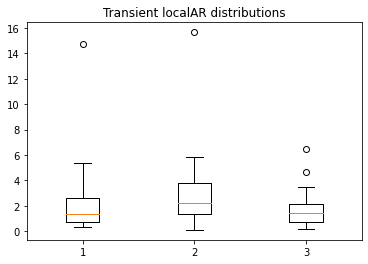

In [11]:

build_analysis_results_table(__last_analysis_results__,kind='slices')[0]

get_global_dyssynchrony_results(__last_analysis_results__)

plot_local_AR(__last_analysis_results__)    
